<a href="https://colab.research.google.com/github/vochicong/ai-memo/blob/master/predict_sin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sin曲線を学習してみる

Sin曲線は [-1,1] の間で規則的に綺麗にカーブを描くので、その曲線の十分な長さの部分から次の値を当てることができるでしょう。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


(4000,) (4000,)
(4000, 1) (4000, 1)


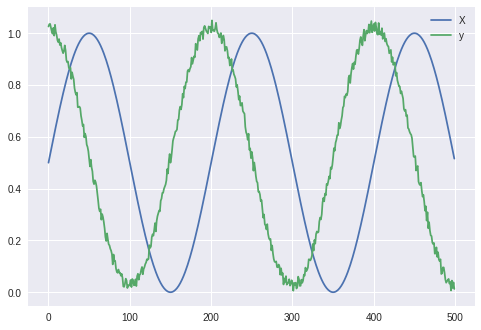

In [2]:
# Sin曲線の1反復あたりのサンプル数
samples_per_cycle = 200
# 生成するSinサイクル数
number_of_cycles = 20
data_len = samples_per_cycle*number_of_cycles
noise  = 0.05
arange = np.arange(data_len) * 2 * np.pi / samples_per_cycle
data = np.sin(arange) * .5 + .5
targets = np.cos(arange) * .5 + .5 + np.random.random_sample((data_len,)) * noise
pd.DataFrame({'y': targets, 'X': data}).head(500).plot()
print(data.shape, targets.shape)
xdim = 1
ydim = 1

data = data.reshape([-1,xdim])
targets = targets.reshape([-1,ydim])

print(data.shape, targets.shape)


In [3]:
seq_len = samples_per_cycle * 3//10
batch_size = 128
gen = TimeseriesGenerator(data, targets,
                               length=seq_len, sampling_rate=1,
                               batch_size=batch_size)
gen[0][0].shape, gen[0][1].shape

((128, 60, 1), (128, 1))

In [0]:
assert np.array_equal(gen[0][0][0], data[0:seq_len])
assert np.array_equal(gen[0][0][1], data[1:seq_len+1])
assert np.array_equal(gen[0][1], targets[seq_len:seq_len+batch_size])

In [5]:

lstm_hidden_units = 300

model = Sequential([
#     Dense(32, input_shape=(seq_len,xdim)), Activation('relu'),
    LSTM(lstm_hidden_units, input_shape=(seq_len,ydim,)
        ),
    Dense(ydim),
    Activation('sigmoid'),
])

model.compile(optimizer='rmsprop', loss='mean_squared_error')
print(model.summary())
early_stop = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=early_stop.patience//2, verbose=1)
model.fit_generator(gen, epochs=20, callbacks=[reduce_lr, early_stop])


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 300)               362400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 301       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 362,701
Trainable params: 362,701
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
31/31 [==============================] - 5s 169ms/step - loss: 0.1374
Epoch 2/20
31/31 [==============================] - 4s 129ms/step - loss: 0.0443
Epoch 3/20
31/31 [==============================] - 4s 128ms/step - loss: 0.0277
Epoch 4/20
31/31 [==============

((3940,), (3940,))

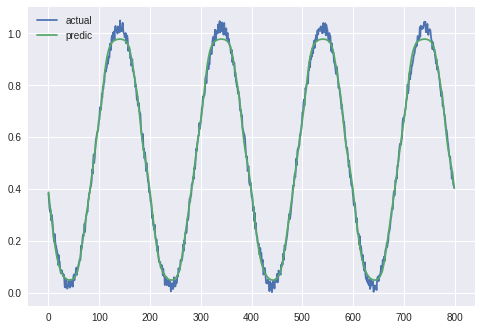

In [6]:
pred = model.predict_generator(gen).flatten()
pd.DataFrame({'actual': targets.flatten()[seq_len:], 'predic': pred.flatten()}).head(samples_per_cycle*4).plot()
pred.shape, targets.flatten()[seq_len:].shape